<table width='100%'>
<tr>
<td style='background-color:white'>
    <p align="left">
    Exercises for the course<br>
        <b>Machine Learning for Data Science</b><br>
    Winter Semester 2024/25
    </p>
</td>
<td style='background-color:white'>
    G. Montavon<br>
    Institute of Computer Science<br>
    <b>Department of Mathematics and Computer Science</b><br>
    Freie Universität Berlin
</td>
</tr>
</table>

<br>
<center>
    <h1>Exercise Sheet 5 (programming part)</h1>
</center>
<br>

In [49]:
import numpy
import scipy
import utils
import sklearn
import sklearn.datasets
import sklearn.decomposition
import torchvision
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
lcm = matplotlib.colors.ListedColormap

## Exercise 3 (10 + 10 P)

In this exercise we perform a clustering of the Iris dataset, which was also used in the previous two assignments.

![](iris_measurements.png)

The dataset associate to each plant instance four measurements. The dataset also includes for each instance the type of iris plant (iris setosa, iris versicolour, iris virginica) which we treat here as metadata. Overall, the Iris dataset has 150 instances, and can be stored as an array of size 150 x 4. The following cell loads the dataset and performs some normalization. We also generate a PCA representation of the data for plotting purposes.

In [50]:
dataset = sklearn.datasets.load_iris()

X = numpy.log(0.1+dataset['data'])
T = dataset['target']

Z = sklearn.decomposition.PCA(2).fit_transform(X)

We focus on one of the simplest clustering methods, which is to find the *connected components* of a graph associated to the dataset. We consider a graph where two nodes are connected if the distance between the corresponding instances (after dataset normalization) is below some threshold value `delta`.

**(a)** Implement this simple clustering method. *(Hint: you can make use of the method `scipy.sparse.csgraph.connected_components` to find the connected components associated to a particular adjacency matrix.)*

In [51]:
class ConnectedComponentsClustering:

    def __init__(self,delta):
        self.delta = delta 
        
    def fit_predict(self,X):
        # compute pairwise distances
        D = sklearn.metrics.pairwise_distances(X)
        
        # create adjecency matrix
        adjecency = (D < self.delta).astype(int)
        
        # find connected components
        n_components, Y = scipy.sparse.csgraph.connected_components(adjecency, directed = False)
        
        return n_components, Y

The algorithm is now applied to the Iris dataset with a particular threshold value `delta = 0.5`. Results are visualized in a PCA plot, where instances are color-coded according to their cluster.

2


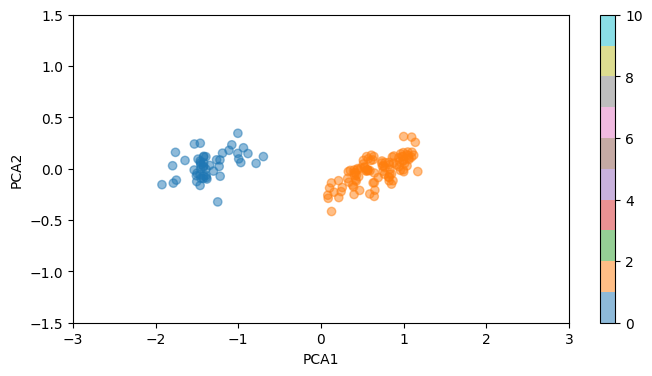

In [52]:
delta = 0.5

n_components, Y = ConnectedComponentsClustering(delta).fit_predict(X)

print(n_components)

utils.preparefigure(1)
plt.scatter(*Z.T,c=Y,cmap='tab10',vmin=0,vmax=10,alpha=0.5)
plt.colorbar()

We observe two clusters. Clusters are consistent with what a human can see in the PCA plot.

**(b)** We now would like to compare the taxonomy derived from the clustering above with the actual iris types available as meta-data. *Write* code that produces a correspondence table linking the clustering to the classification into iris types.

In [53]:
T = dataset['target']
names = dataset['target_names']

def correspondence(names, T, n_components, Y):
    # Initialize correspondence matrix
    correspondence_matrix = [[0] * len(names) for _ in range(n_components)]

    # Populate the table
    for cluster_label in range(n_components):
        for class_label in range(len(names)):
            correspondence_matrix[cluster_label][class_label] = numpy.sum(
                (Y == cluster_label) & (T == class_label)
            )

    # Print the table
    print("Correspondence Table:")
    header = ["Cluster"] + [f"True: {name}" for name in names]
    print("{:<10}".format(header[0]), end="")
    for h in header[1:]:
        print("{:<15}".format(h), end="")
    print()
    print("-" * (10 + 15 * len(names)))

    for cluster_idx, row in enumerate(correspondence_matrix):
        print(f"{'Cluster ' + str(cluster_idx):<10}", end="")
        for count in row:
            print(f"{count:<15}", end="")
        print()

    return correspondence_matrix

correspondence_matrix = correspondence(dataset['target_names'], T, n_components, Y)

Correspondence Table:
Cluster   True: setosa   True: versicolorTrue: virginica
-------------------------------------------------------
Cluster 0 50             0              0              
Cluster 1 0              50             50             


We observe a one-to-one correspondence bewteen cluster 0 and the type iris setosa. The two other iris types (versicolor and virginica) are grouped in the second cluster.

## Exercise 4 (10 + 10 + 10 P)

In this exercise, we consider clustering of fashion items from the FashionMNIST dataset. The FashionMNIST dataset consists of 60000 fashion items, each of which coming as a 28 x 28 grayscale image. For the purpose of limiting computations, we consider a subset of 1000 instances from this dataset, and thus, extract a dataset of size 1000 x 784 (the 784 dimensions correspond to representing images as a flat vector). We also generate a PCA representation of the data for visualization purposes.

In [54]:
X = torchvision.datasets.FashionMNIST('.',download=True).data.numpy()

numpy.random.seed(0)
R = numpy.random.permutation(len(X))[:1000]
X = X[R].reshape(-1,784)

X = X / 255.0

Z = sklearn.decomposition.PCA(n_components=2).fit_transform(X)

The first 50 images of our dataset are visualized below:

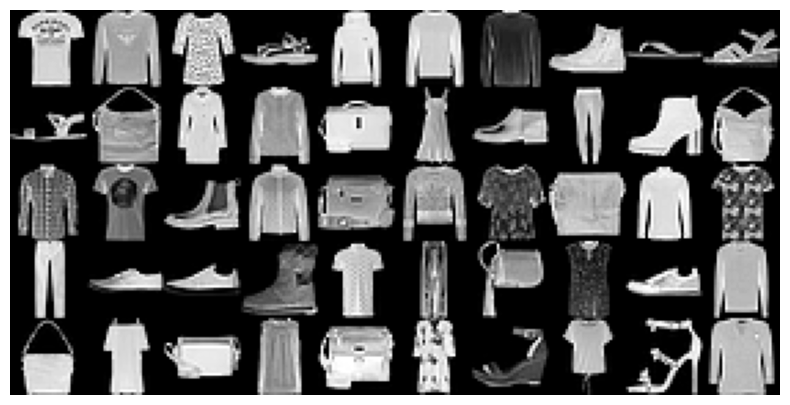

In [55]:
plt.figure(figsize=(10,5))
plt.axis('off')
plt.imshow(X[:50].reshape(5,10,28,28).transpose(0,2,1,3).reshape(5*28,10*28),cmap='gray',vmin=0,vmax=1)
plt.show()

**(a)** Implement a rudimentary version of K-Means, where the cluster centers are initialized to the first few examples of the dataset, and where the number of iterations is fixed to 100.

In [56]:
import sklearn.cluster

class KMeans:
    
    def __init__(self,n_clusters):
        self.n_clusters = n_clusters

    def fit(self,X):
        # Step 1: Initialize cluster centers to the first few examples
        self.cluster_centers_ = X[:self.n_clusters]

        # Step 2: Perform K-Means iterations
        for _ in range(1000):
            # Compute distances between points and cluster centers
            distances = scipy.spatial.distance.cdist(X, self.cluster_centers_)

            # Assign points to the nearest cluster center
            labels = numpy.argmin(distances, axis=1)

            # Update cluster centers as the mean of assigned points
            for k in range(self.n_clusters):
                points_in_cluster = X[labels == k]
                if len(points_in_cluster) > 0:  # Avoid empty clusters
                    self.cluster_centers_[k] = points_in_cluster.mean(axis=0)

    def predict(self,X):
        
        D = scipy.spatial.distance.cdist(X,self.cluster_centers_)
        return numpy.argmin(D,axis=1)

model = KMeans(20)
model.fit(X)

The outcome of your clustering procedure can be visualized in the following PCA plot color-coded by cluster membership.

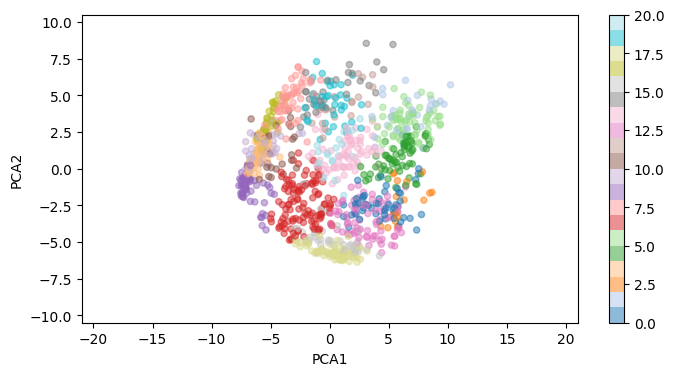

In [57]:
numpy.random.seed(0)
Y = model.predict(X)

utils.preparefigure(7)
plt.scatter(*Z.T,c=Y,s=20,vmin=0,vmax=20,cmap='tab20',alpha=0.5)
plt.colorbar()

**(b)** We now would like to get insights into what are prototypical fashion items in our dataset. For this, we consider the cluster centers learned by k-means. *Extract* these cluster centers and *visualize* them as images.

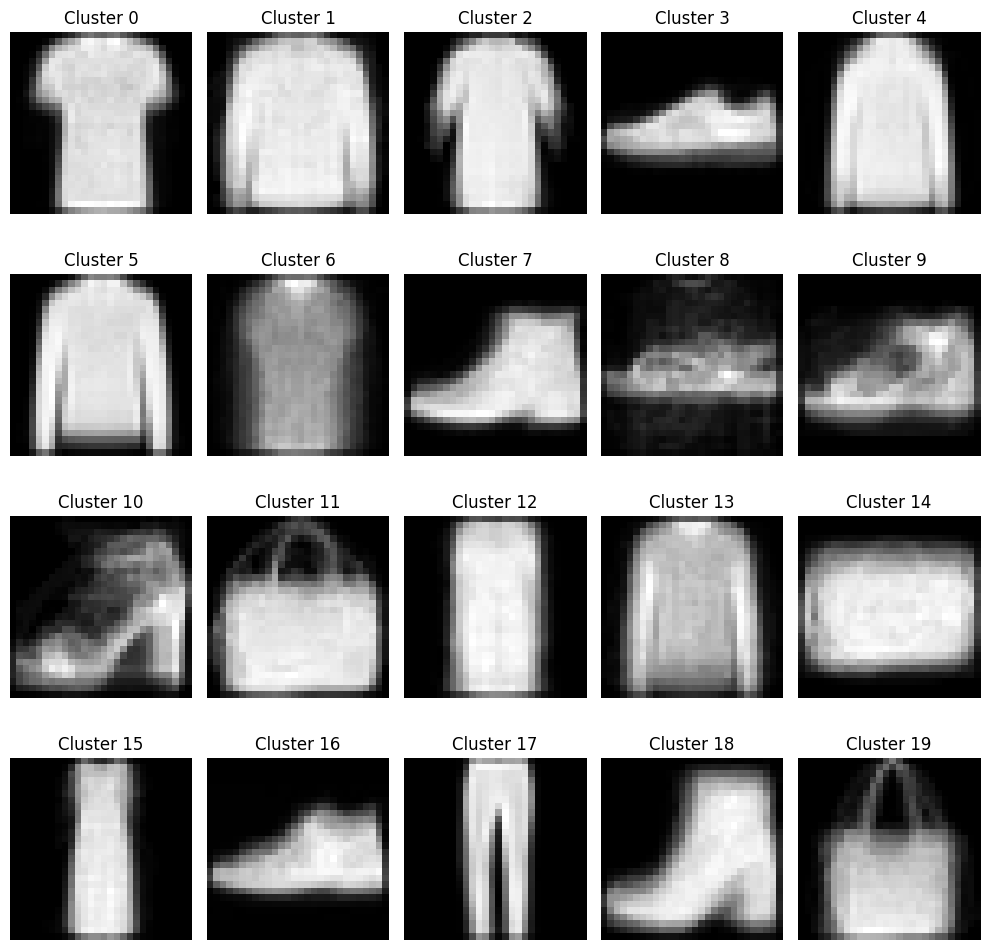

In [58]:
def view_cluster_centers(model):
    """
    Visualize the cluster centers learned by K-Means as images.

    Parameters:
    - model: KMeans
      The fitted KMeans model containing the cluster centers.
    """
    # Extract cluster centers
    cluster_centers = model.cluster_centers_

    # Number of clusters
    n_clusters = cluster_centers.shape[0]

    # Plot cluster centers as images
    plt.figure(figsize=(10, 10))
    
    for i in range(n_clusters):
        # Reshape each cluster center back to a 28x28 image
        image = cluster_centers[i].reshape(28, 28)
        
        # Plot the image
        plt.subplot(4, 5, i + 1)  # Arrange in a 4x5 grid
        plt.imshow(image, cmap="gray")
        plt.axis("off")
        plt.title(f"Cluster {i}")
    
    plt.tight_layout()
    plt.show()
    
view_cluster_centers(model)

**(c)** Lastly, we would like to know how well these cluster centers describe our data. Using the formulas presented in the lecture, compute the total variance, the within-cluster variance, the between-cluster variance, and the percentage of explained variance.

In [65]:
def compute_variances(X, model):
    # Number of samples
    N = X.shape[0]
    
    # Compute the overall mean of the data
    mean_X = numpy.mean(X, axis=0)
    
    # Total variance: average squared distance from the overall mean
    total_variance = numpy.mean(numpy.linalg.norm(X - mean_X, axis=1) ** 2)
    
    # Within-cluster variance
    within_cluster_variance = 0
    for k in range(model.n_clusters):
        cluster_points = X[Y == k]
        cluster_center = model.cluster_centers_[k]
        within_cluster_variance += numpy.sum(numpy.linalg.norm(cluster_points - cluster_center, axis=1) ** 2)
    within_cluster_variance /= N  # Average over all points
    
    # Between-cluster variance
    between_cluster_variance = 0
    for k in range(model.n_clusters):
        cluster_points = X[Y == k]
        n_points_in_cluster = len(cluster_points)
        cluster_center = model.cluster_centers_[k]
        between_cluster_variance += n_points_in_cluster * numpy.linalg.norm(cluster_center - mean_X) ** 2
    
    between_cluster_variance /= N  # Average over all points

    # Percentage of explained variance
    explained_variance_percentage = 100 * between_cluster_variance / total_variance

    return total_variance, within_cluster_variance, between_cluster_variance, explained_variance_percentage

# Example usage
# Assuming 'kmeans' is a fitted KMeans model and 'X' is your data
total_variance, within_cluster_variance, between_cluster_variance, explained_variance_percentage = compute_variances(X, model)

# Print the results
print(f"Total Variance: {total_variance:.2f}")
print(f"Within-Cluster Variance: {within_cluster_variance:.2f}")
print(f"Between-Cluster Variance: {between_cluster_variance:.2f}")
print(f"Explained Variance Percentage: {explained_variance_percentage:.2f}%")

Total Variance: 67.51
Within-Cluster Variance: 26.00
Between-Cluster Variance: 41.51
Explained Variance Percentage: 61.49%


We observe that a bit more than half of the variance in the data is captured by the clustering, which is quite good, considering that the data is high-dimensional. Note that a higher explained variance could be obtained by incorporating more clusters, however that would come at the cost of making the data description potentially too complex for the end user.